# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.072227
Time for [read within]: 0:00:01.124996


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:35.772652
Time for [tag cross test]: 0:00:19.808095
Time for [tag within traindev]: 0:00:36.976236
Time for [tag within test]: 0:00:19.382652


### Get an overview about each dataset

In [9]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

In [ ]:
with Timer("overview within"):
    get_overview(within_traindev_df)

##### Count raw length

In [ ]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.apply(compute_arg_len, axis=1)
within_test_df = within_test_df.apply(compute_arg_len, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

##### Tokenize and count tokens

In [ ]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.apply(tokenize_arguments, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

## Train model - Baseline

### train dev set - 70% 30%

In [10]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [11]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    "1" if str(row['is_same_side']) == "True" else "0"
                ])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

    # for lazy retrieval?
    #
    # def __getitem__(self, idx):
    #     row_X = self._X.iloc[idx]
    #     row_y = self._y.iloc[idx]
    #     return [row_X['argument1'], row_X['argument2'], "1" if row_y['is_same_side'] else "0"]
    #
    # def __len__(self):
    #     return len(self._X)

In [ ]:
# df = X_dev.merge(y_dev, left_index=True, right_index=True)
# allsamples = list()
# for _, row in df.iterrows():
#     allsamples.append("1" if row['is_same_side'] == "True" else "0")
# np.unique(allsamples)

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [12]:
# for chunked arguments, we may have to compute it all at once beforehand, should not be that much
# since we call with any `*BERTSentenceTransform` object, 
#    splitting the lines may have to be done before a transformation of a line?
#    -> chunking / sentence splitting, then feeding the result into the transformer, ...
from mxnet.gluon.data import Dataset, SimpleDataset


class MySimpleDataset(SimpleDataset):
    """Simple Dataset wrapper for lists and arrays.

    Parameters
    ----------
    data : dataset-like object
        Any object that implements `len()` and `[]`.
    """
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]
    
    def transform(self, fn, lazy=True):
        """Returns a new dataset with each sample transformed by the
        transformer function `fn`.

        Parameters
        ----------
        fn : callable
            A transformer function that takes a sample as input and
            returns the transformed sample.
        lazy : bool, default True
            If False, transforms all samples at once. Otherwise,
            transforms each sample on demand. Note that if `fn`
            is stochastic, you must set lazy to True or you will
            get the same result on all epochs.

        Returns
        -------
        Dataset
            The transformed dataset.
        """
        trans = _LazyTransformDataset(self, fn)
        if lazy:
            return trans
        return SimpleDataset([i for i in trans])


class _LazyTransformDataset(Dataset):
    """Lazily transformed dataset."""
    def __init__(self, data, fn):
        self._data = data
        self._fn = fn

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        item = self._data[idx]
        if isinstance(item, tuple):
            return self._fn(*item)
        return self._fn(item)

In [14]:
from gluonnlp.data import BERTSentenceTransform


class LastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(LastPartBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)


# TODO: random trim ? --> bad probably
# TODO: segment-wise, e. g. 0 for normal, 1 for tokens after normal tokens, ...

In [15]:
class LastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(LastPartBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = LastPartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)

In [16]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = bert.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    transform = LastPartBERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [17]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

In [18]:
def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3, checkpoint_dir="data", use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)
            
    return stats

In [19]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss

In [20]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [21]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [22]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.026361


In [23]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [24]:
print(model)

BERTClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): BERTLayerNorm(eps=1e-12, axis

In [25]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [26]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

### Train and evaluate each epoch

100%|██████████| 44732/44732 [03:42<00:00, 201.48it/s]


Time for [setup training]: 0:03:42.046942
[Epoch 0 Batch 10/7459] loss=0.6964, lr=0.0000050, acc=0.500 - time 0:00:09.033741
[Epoch 0 Batch 20/7459] loss=0.7059, lr=0.0000050, acc=0.500 - time 0:00:08.902509
[Epoch 0 Batch 30/7459] loss=0.7019, lr=0.0000050, acc=0.506 - time 0:00:09.230188
[Epoch 0 Batch 40/7459] loss=0.7051, lr=0.0000050, acc=0.496 - time 0:00:08.900182
[Epoch 0 Batch 50/7459] loss=0.7179, lr=0.0000050, acc=0.495 - time 0:00:08.759482
[Epoch 0 Batch 60/7459] loss=0.6964, lr=0.0000050, acc=0.504 - time 0:00:09.171061
[Epoch 0 Batch 70/7459] loss=0.7262, lr=0.0000050, acc=0.492 - time 0:00:09.432729
[Epoch 0 Batch 80/7459] loss=0.6950, lr=0.0000050, acc=0.499 - time 0:00:08.896141
[Epoch 0 Batch 90/7459] loss=0.7012, lr=0.0000050, acc=0.501 - time 0:00:09.058860
[Epoch 0 Batch 100/7459] loss=0.6812, lr=0.0000050, acc=0.509 - time 0:00:09.169101
[Epoch 0 Batch 110/7459] loss=0.7061, lr=0.0000050, acc=0.505 - time 0:00:09.077431
[Epoch 0 Batch 120/7459] loss=0.6839, lr=0.

[Epoch 0 Batch 990/7459] loss=0.6995, lr=0.0000050, acc=0.591 - time 0:00:08.961565
[Epoch 0 Batch 1000/7459] loss=0.6687, lr=0.0000050, acc=0.591 - time 0:00:09.061878
[Epoch 0 Batch 1010/7459] loss=0.6389, lr=0.0000050, acc=0.592 - time 0:00:09.240243
[Epoch 0 Batch 1020/7459] loss=0.5417, lr=0.0000050, acc=0.593 - time 0:00:09.140028
[Epoch 0 Batch 1030/7459] loss=0.6047, lr=0.0000050, acc=0.593 - time 0:00:09.350066
[Epoch 0 Batch 1040/7459] loss=0.5724, lr=0.0000050, acc=0.594 - time 0:00:09.245046
[Epoch 0 Batch 1050/7459] loss=0.6145, lr=0.0000050, acc=0.594 - time 0:00:09.162787
[Epoch 0 Batch 1060/7459] loss=0.6532, lr=0.0000050, acc=0.593 - time 0:00:08.739043
[Epoch 0 Batch 1070/7459] loss=0.6594, lr=0.0000050, acc=0.594 - time 0:00:09.110638
[Epoch 0 Batch 1080/7459] loss=0.5171, lr=0.0000050, acc=0.595 - time 0:00:09.431391
[Epoch 0 Batch 1090/7459] loss=0.6391, lr=0.0000050, acc=0.596 - time 0:00:08.945421
[Epoch 0 Batch 1100/7459] loss=0.7042, lr=0.0000050, acc=0.596 - t

[Epoch 0 Batch 2070/7459] loss=0.5304, lr=0.0000050, acc=0.638 - time 0:00:09.190123
[Epoch 0 Batch 2080/7459] loss=0.4547, lr=0.0000050, acc=0.639 - time 0:00:08.870050
[Epoch 0 Batch 2090/7459] loss=0.3860, lr=0.0000050, acc=0.640 - time 0:00:09.038851
[Epoch 0 Batch 2100/7459] loss=0.4156, lr=0.0000050, acc=0.640 - time 0:00:09.029315
[Epoch 0 Batch 2110/7459] loss=0.6513, lr=0.0000050, acc=0.641 - time 0:00:09.228407
[Epoch 0 Batch 2120/7459] loss=0.3654, lr=0.0000050, acc=0.641 - time 0:00:08.861805
[Epoch 0 Batch 2130/7459] loss=0.6436, lr=0.0000050, acc=0.642 - time 0:00:09.446011
[Epoch 0 Batch 2140/7459] loss=0.6181, lr=0.0000050, acc=0.642 - time 0:00:09.333646
[Epoch 0 Batch 2150/7459] loss=0.5478, lr=0.0000050, acc=0.642 - time 0:00:08.958153
[Epoch 0 Batch 2160/7459] loss=0.5356, lr=0.0000050, acc=0.642 - time 0:00:09.221748
[Epoch 0 Batch 2170/7459] loss=0.4468, lr=0.0000050, acc=0.643 - time 0:00:09.132651
[Epoch 0 Batch 2180/7459] loss=0.5109, lr=0.0000050, acc=0.644 - 

[Epoch 0 Batch 3040/7459] loss=0.5524, lr=0.0000050, acc=0.672 - time 0:00:09.051737
[Epoch 0 Batch 3050/7459] loss=0.4825, lr=0.0000050, acc=0.672 - time 0:00:09.091832
[Epoch 0 Batch 3060/7459] loss=0.3100, lr=0.0000050, acc=0.673 - time 0:00:09.060650
[Epoch 0 Batch 3070/7459] loss=0.4811, lr=0.0000050, acc=0.672 - time 0:00:09.329167
[Epoch 0 Batch 3080/7459] loss=0.3655, lr=0.0000050, acc=0.673 - time 0:00:08.883706
[Epoch 0 Batch 3090/7459] loss=0.4155, lr=0.0000050, acc=0.674 - time 0:00:09.118866
[Epoch 0 Batch 3100/7459] loss=0.4510, lr=0.0000050, acc=0.674 - time 0:00:09.233151
[Epoch 0 Batch 3110/7459] loss=0.5303, lr=0.0000050, acc=0.674 - time 0:00:09.025621
[Epoch 0 Batch 3120/7459] loss=0.3867, lr=0.0000050, acc=0.675 - time 0:00:09.114788
[Epoch 0 Batch 3130/7459] loss=0.3417, lr=0.0000050, acc=0.675 - time 0:00:08.974597
[Epoch 0 Batch 3140/7459] loss=0.3813, lr=0.0000050, acc=0.675 - time 0:00:09.074108
[Epoch 0 Batch 3150/7459] loss=0.5216, lr=0.0000050, acc=0.675 - 

[Epoch 0 Batch 4010/7459] loss=0.3696, lr=0.0000050, acc=0.696 - time 0:00:09.377350
[Epoch 0 Batch 4020/7459] loss=0.4418, lr=0.0000050, acc=0.697 - time 0:00:09.007621
[Epoch 0 Batch 4030/7459] loss=0.3964, lr=0.0000050, acc=0.697 - time 0:00:09.017668
[Epoch 0 Batch 4040/7459] loss=0.5145, lr=0.0000050, acc=0.697 - time 0:00:09.352108
[Epoch 0 Batch 4050/7459] loss=0.2105, lr=0.0000050, acc=0.697 - time 0:00:09.242296
[Epoch 0 Batch 4060/7459] loss=0.3767, lr=0.0000050, acc=0.697 - time 0:00:08.966875
[Epoch 0 Batch 4070/7459] loss=0.3964, lr=0.0000050, acc=0.697 - time 0:00:09.048781
[Epoch 0 Batch 4080/7459] loss=0.4453, lr=0.0000050, acc=0.698 - time 0:00:09.157295
[Epoch 0 Batch 4090/7459] loss=0.2851, lr=0.0000050, acc=0.698 - time 0:00:08.931575
[Epoch 0 Batch 4100/7459] loss=0.4211, lr=0.0000050, acc=0.698 - time 0:00:09.253296
[Epoch 0 Batch 4110/7459] loss=0.3053, lr=0.0000050, acc=0.698 - time 0:00:09.026666
[Epoch 0 Batch 4120/7459] loss=0.2544, lr=0.0000050, acc=0.699 - 

[Epoch 0 Batch 4980/7459] loss=0.3895, lr=0.0000050, acc=0.717 - time 0:00:09.101009
[Epoch 0 Batch 4990/7459] loss=0.3245, lr=0.0000050, acc=0.717 - time 0:00:08.829839
[Epoch 0 Batch 5000/7459] loss=0.3360, lr=0.0000050, acc=0.717 - time 0:00:09.354524
[Epoch 0 Batch 5010/7459] loss=0.2297, lr=0.0000050, acc=0.718 - time 0:00:09.284787
[Epoch 0 Batch 5020/7459] loss=0.2889, lr=0.0000050, acc=0.718 - time 0:00:09.194260
[Epoch 0 Batch 5030/7459] loss=0.3979, lr=0.0000050, acc=0.718 - time 0:00:08.720758
[Epoch 0 Batch 5040/7459] loss=0.3127, lr=0.0000050, acc=0.718 - time 0:00:09.049429
[Epoch 0 Batch 5050/7459] loss=0.3043, lr=0.0000050, acc=0.719 - time 0:00:09.253875
[Epoch 0 Batch 5060/7459] loss=0.2716, lr=0.0000050, acc=0.719 - time 0:00:09.371438
[Epoch 0 Batch 5070/7459] loss=0.3785, lr=0.0000050, acc=0.719 - time 0:00:09.033106
[Epoch 0 Batch 5080/7459] loss=0.3822, lr=0.0000050, acc=0.719 - time 0:00:09.353743
[Epoch 0 Batch 5090/7459] loss=0.3130, lr=0.0000050, acc=0.719 - 

[Epoch 0 Batch 5950/7459] loss=0.2866, lr=0.0000050, acc=0.737 - time 0:00:09.518176
[Epoch 0 Batch 5960/7459] loss=0.2924, lr=0.0000050, acc=0.737 - time 0:00:08.990042
[Epoch 0 Batch 5970/7459] loss=0.3184, lr=0.0000050, acc=0.738 - time 0:00:08.838146
[Epoch 0 Batch 5980/7459] loss=0.3548, lr=0.0000050, acc=0.738 - time 0:00:09.175036
[Epoch 0 Batch 5990/7459] loss=0.1176, lr=0.0000050, acc=0.738 - time 0:00:09.031296
[Epoch 0 Batch 6000/7459] loss=0.2076, lr=0.0000050, acc=0.738 - time 0:00:08.813182
[Epoch 0 Batch 6010/7459] loss=0.3548, lr=0.0000050, acc=0.738 - time 0:00:09.150006
[Epoch 0 Batch 6020/7459] loss=0.1193, lr=0.0000050, acc=0.739 - time 0:00:09.191758
[Epoch 0 Batch 6030/7459] loss=0.1238, lr=0.0000050, acc=0.739 - time 0:00:09.025580
[Epoch 0 Batch 6040/7459] loss=0.4706, lr=0.0000050, acc=0.739 - time 0:00:09.373345
[Epoch 0 Batch 6050/7459] loss=0.2089, lr=0.0000050, acc=0.739 - time 0:00:08.874472
[Epoch 0 Batch 6060/7459] loss=0.2577, lr=0.0000050, acc=0.740 - 

[Epoch 0 Batch 6920/7459] loss=0.2052, lr=0.0000050, acc=0.753 - time 0:00:09.141050
[Epoch 0 Batch 6930/7459] loss=0.3382, lr=0.0000050, acc=0.753 - time 0:00:09.044071
[Epoch 0 Batch 6940/7459] loss=0.4002, lr=0.0000050, acc=0.753 - time 0:00:09.311536
[Epoch 0 Batch 6950/7459] loss=0.3182, lr=0.0000050, acc=0.754 - time 0:00:08.879036
[Epoch 0 Batch 6960/7459] loss=0.3191, lr=0.0000050, acc=0.754 - time 0:00:09.127027
[Epoch 0 Batch 6970/7459] loss=0.2709, lr=0.0000050, acc=0.754 - time 0:00:08.992360
[Epoch 0 Batch 6980/7459] loss=0.3187, lr=0.0000050, acc=0.754 - time 0:00:09.305522
[Epoch 0 Batch 6990/7459] loss=0.1911, lr=0.0000050, acc=0.754 - time 0:00:08.836032
[Epoch 0 Batch 7000/7459] loss=0.4584, lr=0.0000050, acc=0.754 - time 0:00:09.250031
[Epoch 0 Batch 7010/7459] loss=0.2901, lr=0.0000050, acc=0.754 - time 0:00:09.291333
[Epoch 0 Batch 7020/7459] loss=0.4501, lr=0.0000050, acc=0.755 - time 0:00:09.066875
[Epoch 0 Batch 7030/7459] loss=0.4576, lr=0.0000050, acc=0.755 - 

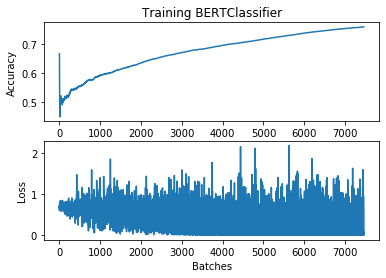

  0%|          | 0/3196 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 1:57:00.600728


100%|██████████| 3196/3196 [11:30<00:00,  4.63it/s]


Time for [prediction]: 0:11:30.245778
Accuracy in epoch 0: 0.8539982264879245
Confusion Matrix:
[[8087  746]
 [2053 8285]]

Accuracy:  0.85 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      8833
           1       0.92      0.80      0.86     10338

    accuracy                           0.85     19171
   macro avg       0.86      0.86      0.85     19171
weighted avg       0.86      0.85      0.85     19171

Time for [6 - evaluate - 0]: 0:11:30.958873


100%|██████████| 44732/44732 [03:45<00:00, 198.03it/s]


Time for [setup training]: 0:03:45.906915
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/7459] loss=0.1391, lr=0.0000050, acc=0.917 - time 0:00:09.039833
[Epoch 1 Batch 20/7459] loss=0.4659, lr=0.0000050, acc=0.858 - time 0:00:08.904891
[Epoch 1 Batch 30/7459] loss=0.3601, lr=0.0000050, acc=0.856 - time 0:00:08.925353
[Epoch 1 Batch 40/7459] loss=0.2272, lr=0.0000050, acc=0.875 - time 0:00:09.329425
[Epoch 1 Batch 50/7459] loss=0.2677, lr=0.0000050, acc=0.877 - time 0:00:08.966246
[Epoch 1 Batch 60/7459] loss=0.1754, lr=0.0000050, acc=0.886 - time 0:00:08.725315
[Epoch 1 Batch 70/7459] loss=0.0761, lr=0.0000050, acc=0.900 - time 0:00:09.045383
[Epoch 1 Batch 80/7459] loss=0.4937, lr=0.0000050, acc=0.881 - time 0:00:09.255609
[Epoch 1 Batch 90/7459] loss=0.4283, lr=0.0000050, acc=0.876 - time 0:00:09.044578
[Epoch 1 Batch 100/7459] loss=0.1221, lr=0.0000050, acc=0.883 - time 0:00:08.759620
[Epoch 1 Batch 110/7459] loss=0.2977, lr=0.0000050, acc=0.885 - time 0:00:09.337108
[Epoch 1 Batc

[Epoch 1 Batch 980/7459] loss=0.3198, lr=0.0000050, acc=0.859 - time 0:00:08.963713
[Epoch 1 Batch 990/7459] loss=0.2326, lr=0.0000050, acc=0.859 - time 0:00:09.129963
[Epoch 1 Batch 1000/7459] loss=0.2558, lr=0.0000050, acc=0.859 - time 0:00:09.395153
[Epoch 1 Batch 1010/7459] loss=0.3729, lr=0.0000050, acc=0.859 - time 0:00:09.416669
[Epoch 1 Batch 1020/7459] loss=0.2865, lr=0.0000050, acc=0.860 - time 0:00:08.657783
[Epoch 1 Batch 1030/7459] loss=0.1921, lr=0.0000050, acc=0.860 - time 0:00:09.146330
[Epoch 1 Batch 1040/7459] loss=0.3205, lr=0.0000050, acc=0.860 - time 0:00:09.175322
[Epoch 1 Batch 1050/7459] loss=0.1788, lr=0.0000050, acc=0.860 - time 0:00:08.735460
[Epoch 1 Batch 1060/7459] loss=0.3250, lr=0.0000050, acc=0.860 - time 0:00:09.010672
[Epoch 1 Batch 1070/7459] loss=0.1832, lr=0.0000050, acc=0.860 - time 0:00:09.258438
[Epoch 1 Batch 1080/7459] loss=0.3339, lr=0.0000050, acc=0.860 - time 0:00:09.380792
[Epoch 1 Batch 1090/7459] loss=0.1260, lr=0.0000050, acc=0.860 - ti

[Epoch 1 Batch 1950/7459] loss=0.4268, lr=0.0000050, acc=0.863 - time 0:00:09.612118
[Epoch 1 Batch 1960/7459] loss=0.3030, lr=0.0000050, acc=0.862 - time 0:00:09.077707
[Epoch 1 Batch 1970/7459] loss=0.3431, lr=0.0000050, acc=0.862 - time 0:00:09.136683
[Epoch 1 Batch 1980/7459] loss=0.1413, lr=0.0000050, acc=0.863 - time 0:00:09.003282
[Epoch 1 Batch 1990/7459] loss=0.1574, lr=0.0000050, acc=0.863 - time 0:00:09.297285
[Epoch 1 Batch 2000/7459] loss=0.1113, lr=0.0000050, acc=0.863 - time 0:00:08.620068
[Epoch 1 Batch 2010/7459] loss=0.3028, lr=0.0000050, acc=0.863 - time 0:00:09.162884
[Epoch 1 Batch 2020/7459] loss=0.3349, lr=0.0000050, acc=0.863 - time 0:00:09.404488
[Epoch 1 Batch 2030/7459] loss=0.2620, lr=0.0000050, acc=0.863 - time 0:00:09.128607
[Epoch 1 Batch 2040/7459] loss=0.4129, lr=0.0000050, acc=0.863 - time 0:00:08.917524
[Epoch 1 Batch 2050/7459] loss=0.4308, lr=0.0000050, acc=0.863 - time 0:00:09.409385
[Epoch 1 Batch 2060/7459] loss=0.2378, lr=0.0000050, acc=0.863 - 

[Epoch 1 Batch 2920/7459] loss=0.2326, lr=0.0000050, acc=0.863 - time 0:00:08.954914
[Epoch 1 Batch 2930/7459] loss=0.3850, lr=0.0000050, acc=0.863 - time 0:00:09.011930
[Epoch 1 Batch 2940/7459] loss=0.2964, lr=0.0000050, acc=0.863 - time 0:00:08.976561
[Epoch 1 Batch 2950/7459] loss=0.2353, lr=0.0000050, acc=0.863 - time 0:00:09.144411
[Epoch 1 Batch 2960/7459] loss=0.3424, lr=0.0000050, acc=0.863 - time 0:00:09.206000
[Epoch 1 Batch 2970/7459] loss=0.3418, lr=0.0000050, acc=0.863 - time 0:00:09.515444
[Epoch 1 Batch 2980/7459] loss=0.1650, lr=0.0000050, acc=0.863 - time 0:00:09.001225
[Epoch 1 Batch 2990/7459] loss=0.4432, lr=0.0000050, acc=0.863 - time 0:00:09.695414
[Epoch 1 Batch 3000/7459] loss=0.2961, lr=0.0000050, acc=0.863 - time 0:00:09.243267
[Epoch 1 Batch 3010/7459] loss=0.2496, lr=0.0000050, acc=0.863 - time 0:00:09.055398
[Epoch 1 Batch 3020/7459] loss=0.2575, lr=0.0000050, acc=0.863 - time 0:00:08.839438
[Epoch 1 Batch 3030/7459] loss=0.2663, lr=0.0000050, acc=0.864 - 

[Epoch 1 Batch 3890/7459] loss=0.2146, lr=0.0000050, acc=0.864 - time 0:00:08.915471
[Epoch 1 Batch 3900/7459] loss=0.2251, lr=0.0000050, acc=0.864 - time 0:00:09.175747
[Epoch 1 Batch 3910/7459] loss=0.3112, lr=0.0000050, acc=0.864 - time 0:00:09.328062
[Epoch 1 Batch 3920/7459] loss=0.2148, lr=0.0000050, acc=0.864 - time 0:00:08.838298
[Epoch 1 Batch 3930/7459] loss=0.2532, lr=0.0000050, acc=0.864 - time 0:00:08.772033
[Epoch 1 Batch 3940/7459] loss=0.4134, lr=0.0000050, acc=0.864 - time 0:00:09.520495
[Epoch 1 Batch 3950/7459] loss=0.2514, lr=0.0000050, acc=0.864 - time 0:00:08.972679
[Epoch 1 Batch 3960/7459] loss=0.3203, lr=0.0000050, acc=0.864 - time 0:00:09.008050
[Epoch 1 Batch 3970/7459] loss=0.2418, lr=0.0000050, acc=0.865 - time 0:00:09.025421
[Epoch 1 Batch 3980/7459] loss=0.3951, lr=0.0000050, acc=0.865 - time 0:00:09.546821
[Epoch 1 Batch 3990/7459] loss=0.2940, lr=0.0000050, acc=0.865 - time 0:00:09.607640
[Epoch 1 Batch 4000/7459] loss=0.1789, lr=0.0000050, acc=0.865 - 

[Epoch 1 Batch 4860/7459] loss=0.4960, lr=0.0000050, acc=0.866 - time 0:00:08.994309
[Epoch 1 Batch 4870/7459] loss=0.3244, lr=0.0000050, acc=0.866 - time 0:00:09.044712
[Epoch 1 Batch 4880/7459] loss=0.3119, lr=0.0000050, acc=0.866 - time 0:00:08.795859
[Epoch 1 Batch 4890/7459] loss=0.2905, lr=0.0000050, acc=0.866 - time 0:00:09.342396
[Epoch 1 Batch 4900/7459] loss=0.2256, lr=0.0000050, acc=0.866 - time 0:00:09.300949
[Epoch 1 Batch 4910/7459] loss=0.0375, lr=0.0000050, acc=0.866 - time 0:00:08.912289
[Epoch 1 Batch 4920/7459] loss=0.2173, lr=0.0000050, acc=0.866 - time 0:00:08.987812
[Epoch 1 Batch 4930/7459] loss=0.3358, lr=0.0000050, acc=0.866 - time 0:00:09.323114
[Epoch 1 Batch 4940/7459] loss=0.1658, lr=0.0000050, acc=0.866 - time 0:00:09.050416
[Epoch 1 Batch 4950/7459] loss=0.3696, lr=0.0000050, acc=0.866 - time 0:00:08.874331
[Epoch 1 Batch 4960/7459] loss=0.4003, lr=0.0000050, acc=0.866 - time 0:00:08.903732
[Epoch 1 Batch 4970/7459] loss=0.2075, lr=0.0000050, acc=0.866 - 

[Epoch 1 Batch 5830/7459] loss=0.2962, lr=0.0000050, acc=0.867 - time 0:00:09.210410
[Epoch 1 Batch 5840/7459] loss=0.2569, lr=0.0000050, acc=0.866 - time 0:00:09.562897
[Epoch 1 Batch 5850/7459] loss=0.2362, lr=0.0000050, acc=0.866 - time 0:00:08.993222
[Epoch 1 Batch 5860/7459] loss=0.4301, lr=0.0000050, acc=0.866 - time 0:00:09.180923
[Epoch 1 Batch 5870/7459] loss=0.4281, lr=0.0000050, acc=0.866 - time 0:00:08.891742
[Epoch 1 Batch 5880/7459] loss=0.2979, lr=0.0000050, acc=0.866 - time 0:00:09.356834
[Epoch 1 Batch 5890/7459] loss=0.0335, lr=0.0000050, acc=0.866 - time 0:00:08.848517
[Epoch 1 Batch 5900/7459] loss=0.1819, lr=0.0000050, acc=0.866 - time 0:00:08.824303
[Epoch 1 Batch 5910/7459] loss=0.1465, lr=0.0000050, acc=0.867 - time 0:00:08.942909
[Epoch 1 Batch 5920/7459] loss=0.2184, lr=0.0000050, acc=0.867 - time 0:00:09.202825
[Epoch 1 Batch 5930/7459] loss=0.1169, lr=0.0000050, acc=0.867 - time 0:00:09.155271
[Epoch 1 Batch 5940/7459] loss=0.1825, lr=0.0000050, acc=0.867 - 

[Epoch 1 Batch 6800/7459] loss=0.2973, lr=0.0000050, acc=0.868 - time 0:00:09.506930
[Epoch 1 Batch 6810/7459] loss=0.2086, lr=0.0000050, acc=0.868 - time 0:00:09.006636
[Epoch 1 Batch 6820/7459] loss=0.4430, lr=0.0000050, acc=0.868 - time 0:00:09.088080
[Epoch 1 Batch 6830/7459] loss=0.3609, lr=0.0000050, acc=0.868 - time 0:00:09.265699
[Epoch 1 Batch 6840/7459] loss=0.3048, lr=0.0000050, acc=0.868 - time 0:00:09.069020
[Epoch 1 Batch 6850/7459] loss=0.2800, lr=0.0000050, acc=0.868 - time 0:00:09.137149
[Epoch 1 Batch 6860/7459] loss=0.5355, lr=0.0000050, acc=0.868 - time 0:00:09.223453
[Epoch 1 Batch 6870/7459] loss=0.2620, lr=0.0000050, acc=0.868 - time 0:00:09.172170
[Epoch 1 Batch 6880/7459] loss=0.2624, lr=0.0000050, acc=0.868 - time 0:00:09.478381
[Epoch 1 Batch 6890/7459] loss=0.2846, lr=0.0000050, acc=0.868 - time 0:00:09.189216
[Epoch 1 Batch 6900/7459] loss=0.4639, lr=0.0000050, acc=0.868 - time 0:00:08.717225
[Epoch 1 Batch 6910/7459] loss=0.2493, lr=0.0000050, acc=0.868 - 

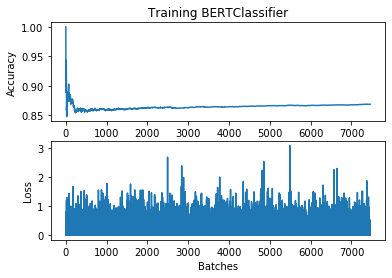

  0%|          | 0/3196 [00:00<?, ?it/s]

Time for [4 - train model - 1]: 1:57:15.269506


100%|██████████| 3196/3196 [11:34<00:00,  4.60it/s]


Time for [prediction]: 0:11:34.644264
Accuracy in epoch 1: 0.8713160502842836
Confusion Matrix:
[[7984  849]
 [1618 8720]]

Accuracy:  0.87 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      8833
           1       0.91      0.84      0.88     10338

    accuracy                           0.87     19171
   macro avg       0.87      0.87      0.87     19171
weighted avg       0.87      0.87      0.87     19171

Time for [6 - evaluate - 1]: 0:11:35.459518


100%|██████████| 44732/44732 [03:46<00:00, 197.15it/s]


Time for [setup training]: 0:03:46.920380
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/7459] loss=0.0591, lr=0.0000050, acc=0.983 - time 0:00:08.854197
[Epoch 2 Batch 20/7459] loss=0.2030, lr=0.0000050, acc=0.925 - time 0:00:09.288578
[Epoch 2 Batch 30/7459] loss=0.1618, lr=0.0000050, acc=0.922 - time 0:00:09.318430
[Epoch 2 Batch 40/7459] loss=0.3073, lr=0.0000050, acc=0.912 - time 0:00:09.194466
[Epoch 2 Batch 50/7459] loss=0.1697, lr=0.0000050, acc=0.920 - time 0:00:08.599783
[Epoch 2 Batch 60/7459] loss=0.3223, lr=0.0000050, acc=0.919 - time 0:00:09.146914
[Epoch 2 Batch 70/7459] loss=0.1450, lr=0.0000050, acc=0.924 - time 0:00:09.075689
[Epoch 2 Batch 80/7459] loss=0.2114, lr=0.0000050, acc=0.925 - time 0:00:08.973085
[Epoch 2 Batch 90/7459] loss=0.1590, lr=0.0000050, acc=0.928 - time 0:00:08.937820
[Epoch 2 Batch 100/7459] loss=0.2290, lr=0.0000050, acc=0.925 - time 0:00:08.964153
[Epoch 2 Batch 110/7459] loss=0.3519, lr=0.0000050, acc=0.926 - tim

[Epoch 2 Batch 980/7459] loss=0.0918, lr=0.0000050, acc=0.896 - time 0:00:08.760714
[Epoch 2 Batch 990/7459] loss=0.2232, lr=0.0000050, acc=0.897 - time 0:00:09.206254
[Epoch 2 Batch 1000/7459] loss=0.3193, lr=0.0000050, acc=0.897 - time 0:00:09.539617
[Epoch 2 Batch 1010/7459] loss=0.3425, lr=0.0000050, acc=0.896 - time 0:00:09.199563
[Epoch 2 Batch 1020/7459] loss=0.0852, lr=0.0000050, acc=0.897 - time 0:00:08.857575
[Epoch 2 Batch 1030/7459] loss=0.3130, lr=0.0000050, acc=0.897 - time 0:00:09.485443
[Epoch 2 Batch 1040/7459] loss=0.4366, lr=0.0000050, acc=0.896 - time 0:00:09.272828
[Epoch 2 Batch 1050/7459] loss=0.0517, lr=0.0000050, acc=0.897 - time 0:00:08.819436
[Epoch 2 Batch 1060/7459] loss=0.3772, lr=0.0000050, acc=0.896 - time 0:00:09.120883
[Epoch 2 Batch 1070/7459] loss=0.1077, lr=0.0000050, acc=0.897 - time 0:00:09.113585
[Epoch 2 Batch 1080/7459] loss=0.0955, lr=0.0000050, acc=0.898 - time 0:00:08.856905
[Epoch 2 Batch 1090/7459] loss=0.1553, lr=0.0000050, acc=0.898 - ti

[Epoch 2 Batch 1950/7459] loss=0.3544, lr=0.0000050, acc=0.902 - time 0:00:09.324903
[Epoch 2 Batch 1960/7459] loss=0.1025, lr=0.0000050, acc=0.902 - time 0:00:08.848733
[Epoch 2 Batch 1970/7459] loss=0.0810, lr=0.0000050, acc=0.903 - time 0:00:08.879947
[Epoch 2 Batch 1980/7459] loss=0.2765, lr=0.0000050, acc=0.903 - time 0:00:09.102641
[Epoch 2 Batch 1990/7459] loss=0.3957, lr=0.0000050, acc=0.902 - time 0:00:09.299076
[Epoch 2 Batch 2000/7459] loss=0.4970, lr=0.0000050, acc=0.902 - time 0:00:08.905040
[Epoch 2 Batch 2010/7459] loss=0.2371, lr=0.0000050, acc=0.902 - time 0:00:08.982322
[Epoch 2 Batch 2020/7459] loss=0.2627, lr=0.0000050, acc=0.902 - time 0:00:09.317308
[Epoch 2 Batch 2030/7459] loss=0.3171, lr=0.0000050, acc=0.902 - time 0:00:09.400695
[Epoch 2 Batch 2040/7459] loss=0.1915, lr=0.0000050, acc=0.902 - time 0:00:08.852178
[Epoch 2 Batch 2050/7459] loss=0.2900, lr=0.0000050, acc=0.902 - time 0:00:09.392111
[Epoch 2 Batch 2060/7459] loss=0.2605, lr=0.0000050, acc=0.901 - 

[Epoch 2 Batch 2920/7459] loss=0.1678, lr=0.0000050, acc=0.899 - time 0:00:08.895804
[Epoch 2 Batch 2930/7459] loss=0.1415, lr=0.0000050, acc=0.899 - time 0:00:09.015901
[Epoch 2 Batch 2940/7459] loss=0.5914, lr=0.0000050, acc=0.899 - time 0:00:09.229158
[Epoch 2 Batch 2950/7459] loss=0.4138, lr=0.0000050, acc=0.899 - time 0:00:09.120560
[Epoch 2 Batch 2960/7459] loss=0.2168, lr=0.0000050, acc=0.899 - time 0:00:08.929826
[Epoch 2 Batch 2970/7459] loss=0.1941, lr=0.0000050, acc=0.899 - time 0:00:09.202041
[Epoch 2 Batch 2980/7459] loss=0.3726, lr=0.0000050, acc=0.898 - time 0:00:09.653440
[Epoch 2 Batch 2990/7459] loss=0.1924, lr=0.0000050, acc=0.899 - time 0:00:08.833343
[Epoch 2 Batch 3000/7459] loss=0.2642, lr=0.0000050, acc=0.899 - time 0:00:08.942884
[Epoch 2 Batch 3010/7459] loss=0.3982, lr=0.0000050, acc=0.898 - time 0:00:09.491383
[Epoch 2 Batch 3020/7459] loss=0.2182, lr=0.0000050, acc=0.899 - time 0:00:09.303128
[Epoch 2 Batch 3030/7459] loss=0.1050, lr=0.0000050, acc=0.899 - 

[Epoch 2 Batch 3890/7459] loss=0.1957, lr=0.0000050, acc=0.898 - time 0:00:09.180861
[Epoch 2 Batch 3900/7459] loss=0.2098, lr=0.0000050, acc=0.898 - time 0:00:09.365900
[Epoch 2 Batch 3910/7459] loss=0.1269, lr=0.0000050, acc=0.898 - time 0:00:08.757166
[Epoch 2 Batch 3920/7459] loss=0.4706, lr=0.0000050, acc=0.898 - time 0:00:09.141918
[Epoch 2 Batch 3930/7459] loss=0.1895, lr=0.0000050, acc=0.898 - time 0:00:09.136908
[Epoch 2 Batch 3940/7459] loss=0.1677, lr=0.0000050, acc=0.898 - time 0:00:09.041525
[Epoch 2 Batch 3950/7459] loss=0.3966, lr=0.0000050, acc=0.898 - time 0:00:09.053496
[Epoch 2 Batch 3960/7459] loss=0.3818, lr=0.0000050, acc=0.898 - time 0:00:09.054843
[Epoch 2 Batch 3970/7459] loss=0.2174, lr=0.0000050, acc=0.898 - time 0:00:09.096242
[Epoch 2 Batch 3980/7459] loss=0.1979, lr=0.0000050, acc=0.898 - time 0:00:09.228959
[Epoch 2 Batch 3990/7459] loss=0.3287, lr=0.0000050, acc=0.897 - time 0:00:09.052939
[Epoch 2 Batch 4000/7459] loss=0.1976, lr=0.0000050, acc=0.897 - 

[Epoch 2 Batch 4860/7459] loss=0.4375, lr=0.0000050, acc=0.898 - time 0:00:09.121494
[Epoch 2 Batch 4870/7459] loss=0.2252, lr=0.0000050, acc=0.898 - time 0:00:09.293912
[Epoch 2 Batch 4880/7459] loss=0.1974, lr=0.0000050, acc=0.898 - time 0:00:09.477911
[Epoch 2 Batch 4890/7459] loss=0.3810, lr=0.0000050, acc=0.898 - time 0:00:09.386150
[Epoch 2 Batch 4900/7459] loss=0.1413, lr=0.0000050, acc=0.898 - time 0:00:08.876016
[Epoch 2 Batch 4910/7459] loss=0.2286, lr=0.0000050, acc=0.898 - time 0:00:09.060380
[Epoch 2 Batch 4920/7459] loss=0.1296, lr=0.0000050, acc=0.898 - time 0:00:09.248846
[Epoch 2 Batch 4930/7459] loss=0.2651, lr=0.0000050, acc=0.898 - time 0:00:09.375724
[Epoch 2 Batch 4940/7459] loss=0.2765, lr=0.0000050, acc=0.898 - time 0:00:08.982364
[Epoch 2 Batch 4950/7459] loss=0.3339, lr=0.0000050, acc=0.898 - time 0:00:09.573291
[Epoch 2 Batch 4960/7459] loss=0.1634, lr=0.0000050, acc=0.898 - time 0:00:08.970666
[Epoch 2 Batch 4970/7459] loss=0.1096, lr=0.0000050, acc=0.898 - 

[Epoch 2 Batch 5830/7459] loss=0.0717, lr=0.0000050, acc=0.900 - time 0:00:09.173598
[Epoch 2 Batch 5840/7459] loss=0.0894, lr=0.0000050, acc=0.900 - time 0:00:08.720146
[Epoch 2 Batch 5850/7459] loss=0.4526, lr=0.0000050, acc=0.900 - time 0:00:09.429184
[Epoch 2 Batch 5860/7459] loss=0.2009, lr=0.0000050, acc=0.900 - time 0:00:09.481024
[Epoch 2 Batch 5870/7459] loss=0.1315, lr=0.0000050, acc=0.900 - time 0:00:09.100806
[Epoch 2 Batch 5880/7459] loss=0.2898, lr=0.0000050, acc=0.900 - time 0:00:09.154788
[Epoch 2 Batch 5890/7459] loss=0.2288, lr=0.0000050, acc=0.900 - time 0:00:09.383810
[Epoch 2 Batch 5900/7459] loss=0.2474, lr=0.0000050, acc=0.900 - time 0:00:09.024940
[Epoch 2 Batch 5910/7459] loss=0.1711, lr=0.0000050, acc=0.900 - time 0:00:08.874789
[Epoch 2 Batch 5920/7459] loss=0.2856, lr=0.0000050, acc=0.900 - time 0:00:09.300468
[Epoch 2 Batch 5930/7459] loss=0.1627, lr=0.0000050, acc=0.900 - time 0:00:09.048845
[Epoch 2 Batch 5940/7459] loss=0.2557, lr=0.0000050, acc=0.900 - 

[Epoch 2 Batch 6800/7459] loss=0.1802, lr=0.0000050, acc=0.901 - time 0:00:09.014620
[Epoch 2 Batch 6810/7459] loss=0.1023, lr=0.0000050, acc=0.901 - time 0:00:09.113807
[Epoch 2 Batch 6820/7459] loss=0.2603, lr=0.0000050, acc=0.901 - time 0:00:09.073200
[Epoch 2 Batch 6830/7459] loss=0.2464, lr=0.0000050, acc=0.901 - time 0:00:09.075633
[Epoch 2 Batch 6840/7459] loss=0.1370, lr=0.0000050, acc=0.901 - time 0:00:09.270469
[Epoch 2 Batch 6850/7459] loss=0.1264, lr=0.0000050, acc=0.901 - time 0:00:09.249581
[Epoch 2 Batch 6860/7459] loss=0.2665, lr=0.0000050, acc=0.901 - time 0:00:09.245182
[Epoch 2 Batch 6870/7459] loss=0.3454, lr=0.0000050, acc=0.901 - time 0:00:09.231867
[Epoch 2 Batch 6880/7459] loss=0.0602, lr=0.0000050, acc=0.901 - time 0:00:09.027098
[Epoch 2 Batch 6890/7459] loss=0.1006, lr=0.0000050, acc=0.902 - time 0:00:08.885394
[Epoch 2 Batch 6900/7459] loss=0.2262, lr=0.0000050, acc=0.902 - time 0:00:08.999108
[Epoch 2 Batch 6910/7459] loss=0.3442, lr=0.0000050, acc=0.902 - 

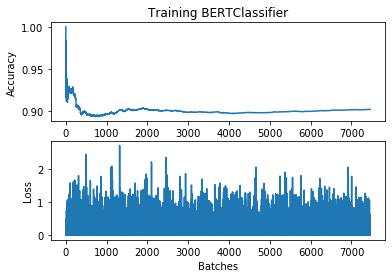

  0%|          | 0/3196 [00:00<?, ?it/s]

Time for [4 - train model - 2]: 1:57:39.095422


100%|██████████| 3196/3196 [11:34<00:00,  4.60it/s]


Time for [prediction]: 0:11:34.085387
Accuracy in epoch 2: 0.8836784726931303
Confusion Matrix:
[[7984  849]
 [1381 8957]]

Accuracy:  0.88 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      8833
           1       0.91      0.87      0.89     10338

    accuracy                           0.88     19171
   macro avg       0.88      0.89      0.88     19171
weighted avg       0.89      0.88      0.88     19171

Time for [6 - evaluate - 2]: 0:11:34.832694


  4%|▍         | 1853/44732 [00:09<05:54, 120.90it/s]

Time for [setup training]: 0:00:09.514955
Time for [4 - train model - 3]: 0:00:09.515187


KeyboardInterrupt: 

In [27]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")